In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mplc
import pysal as ps
from pysal.contrib import compact as com
from shapely import geometry as sgeom
import descartes as des
%matplotlib inline

In [2]:
data = ps.open(ps.examples.get_path('columbus.shp')).read()
chains = [chain.parts[0] for chain in data]

In [3]:
points = chains[0]
points

[(8.624129295349121, 14.236980438232422),
 (8.559700012207031, 14.742449760437012),
 (8.809452056884766, 14.734430313110352),
 (8.808412551879883, 14.636520385742188),
 (8.919304847717285, 14.638500213623047),
 (9.087138175964355, 14.63049030303955),
 (9.09996509552002, 14.244830131530762),
 (9.015047073364258, 14.241840362548828),
 (9.008951187133789, 13.995059967041016),
 (8.818140029907227, 14.002050399780273),
 (8.653305053710938, 14.008090019226074),
 (8.642902374267578, 14.089710235595703),
 (8.63259220123291, 14.1705904006958),
 (8.625825881958008, 14.22367000579834),
 (8.624129295349121, 14.236980438232422)]

Let's plot that polygon by interpreting it in Shapely and using its draw behavior.

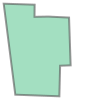

In [4]:
poly = sgeom.Polygon(points)
poly

Nifty. Now, I've implemented Skyum's method for finding the Minimum Bounding Circle for a set of points in `centrography`. 

Right now, there's some extra printing. Essentially, if you have sufficiently straight lines on the boundary, the equations for the circumcenter of the tuple $(p,q,r)$ explodes. Thus, I test if $\angle (p,q,r)$ identifies a circle whose diameter is $(p,r)$ or $(p,q)$. There are two triplets of straight enough lines, so their circle equations are modified, and I retain printing for bug diagnostics.

In [5]:
points = [points[i] for i in com.mbc.ConvexHull(points).vertices]

In [6]:
points.reverse()
com.mbc.not_clockwise(points)

False

In [7]:
angles = [com.mbc._angle(*com.mbc._neighb(p, points)) for p in points]

In [8]:
circles = [com.mbc._circle(*com.mbc._neighb(p, points)) for p in points]

In [9]:
radii = [c[0] for c in circles]

In [10]:
lexord = com.np.lexsort((radii, angles))
lexmax = lexord[-1]

In [11]:
print('index: ', lexmax)
print('angle: ', angles[lexmax])
print('radius: {} \t center: {}'.format(circles[lexmax][0], circles[lexmax][1]))
print('neighborhood: {}'.format(com.mbc._neighb(points[lexmax], points)))

('index: ', 2)
('angle: ', 3.1415906838968697)
radius: 187923.044049 	 center: (186423.38528591557, 23775.703847336634)
neighborhood: ((8.653305053710938, 14.008090019226074), (8.625825881958008, 14.22367000579834), (8.559700012207031, 14.742449760437012))


In [12]:
if not angles[lexmax] <= com.mbc.PI/2.:
    points.pop(lexmax)

In [13]:
radius, center = com.mbc.minimum_bounding_circle(points)
#p,q,r = cent.skyum(points)
#mbc = cent._circle(points[p], points[q], points[r])
#mbc = cent._circle()
mbc_poly = sgeom.Point(*center).buffer(radius)

In [14]:
radius, center

(0.43600978241479343, (8.78432559967041, 14.368754863739014))

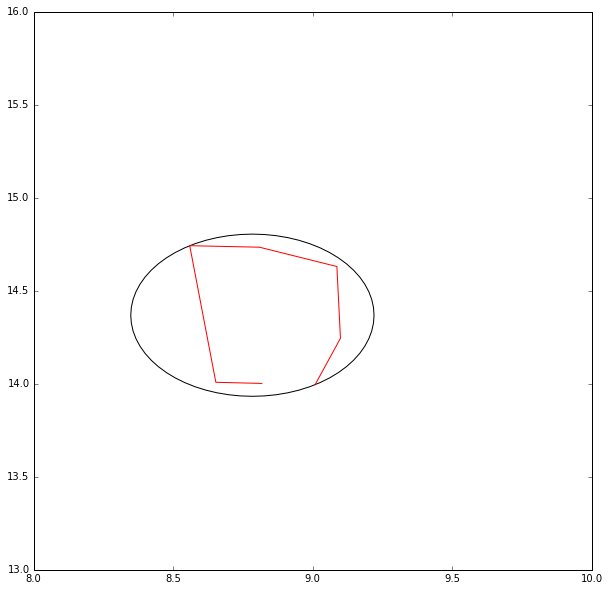

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlim(8, 10)
ax.set_ylim(13,16)
ax.plot([p[0] for p in points], [p[-1] for p in points], 'r')
ax.add_patch(des.PolygonPatch(mbc_poly, fc='white', ec='black'))
plt.show()

### Cool. How fast is this?

In [17]:
import time

In [20]:
def demo_mbc(chains):
    for cidx, chain in enumerate(chains):
        points = chain
        start = time.time()
        (radius, center) = com.mbc.minimum_bounding_circle(chain)
        elapsed = time.time() - start
        mbc_poly = sgeom.Point(*center).buffer(radius)
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        parray = ps.common.np.array(points)
        ax.set_xlim(parray[:,0].min()*.98, parray[:,0].max()*1.02)
        ax.set_ylim(parray[:,1].min()*.98, parray[:,1].max()*1.02)
        ax.plot([p[0] for p in points], [p[-1] for p in points], 'r')
        ax.add_patch(des.PolygonPatch(mbc_poly, fc='white', ec='black'))
        plt.title('Shape #{}, Elapsed Time: {}'.format(cidx, elapsed))
        plt.show()
        plt.clf()

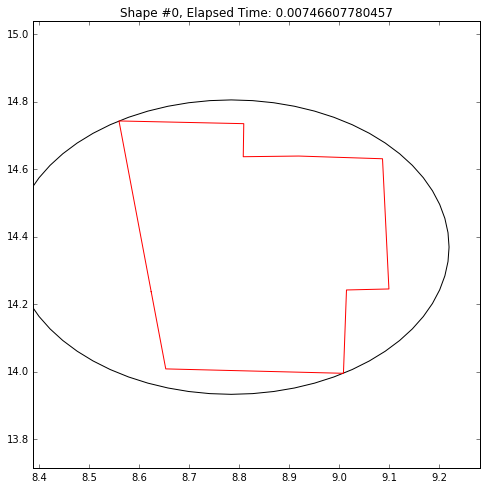

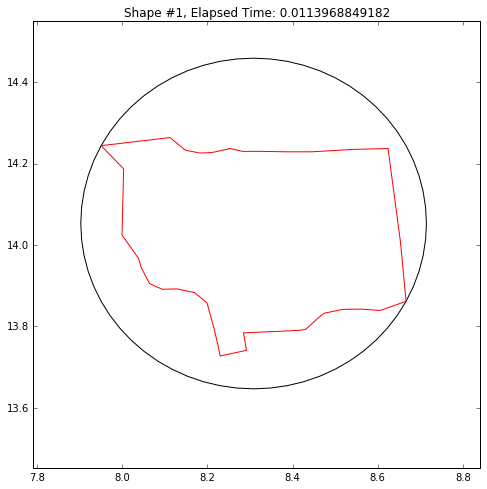

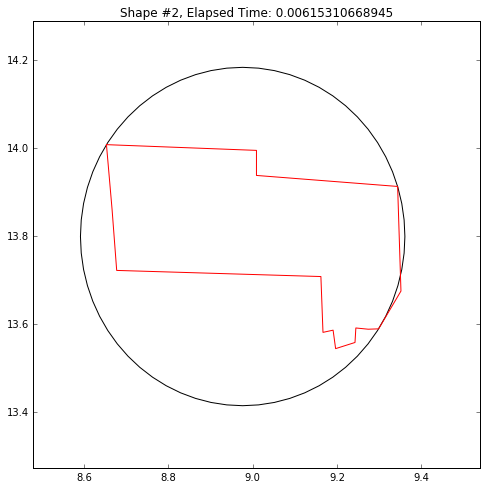

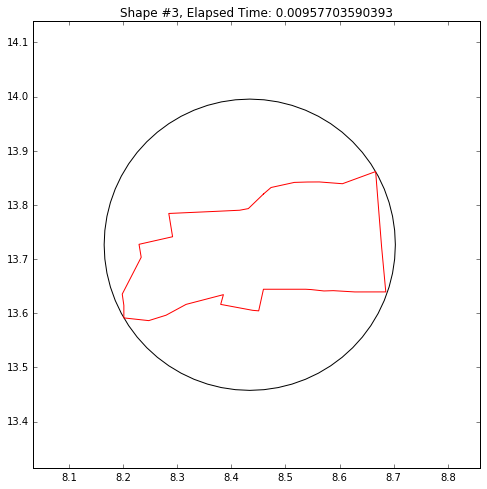

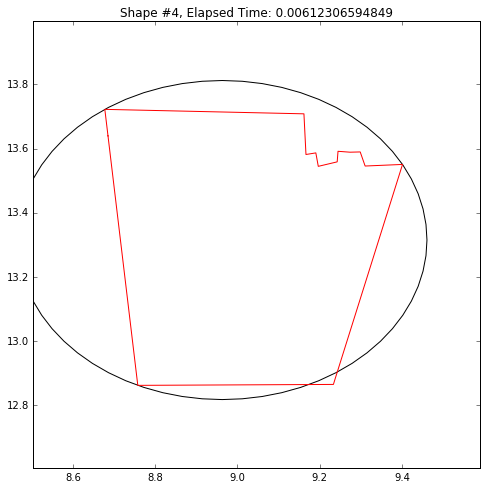

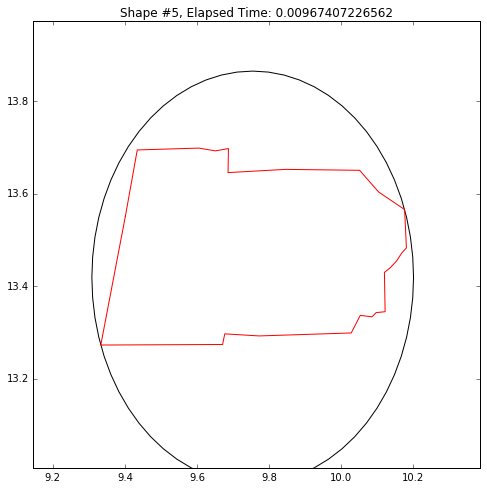

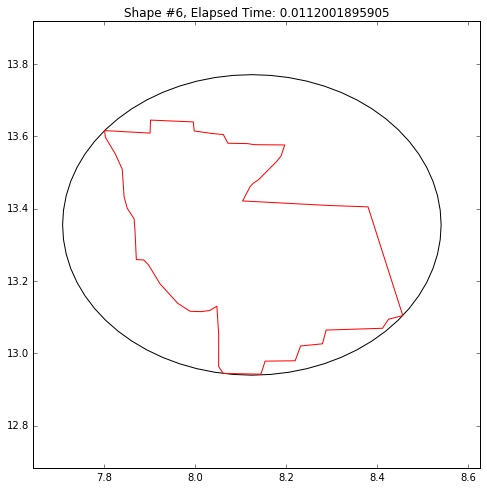

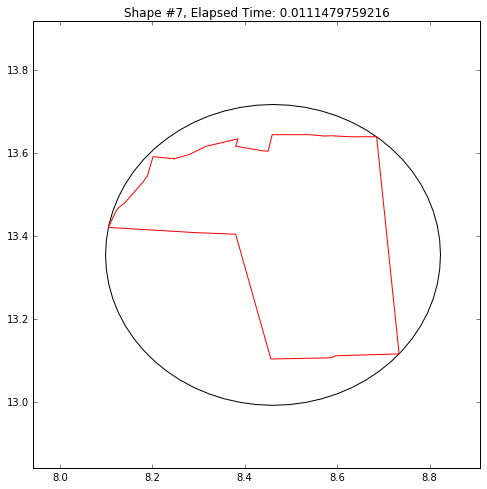

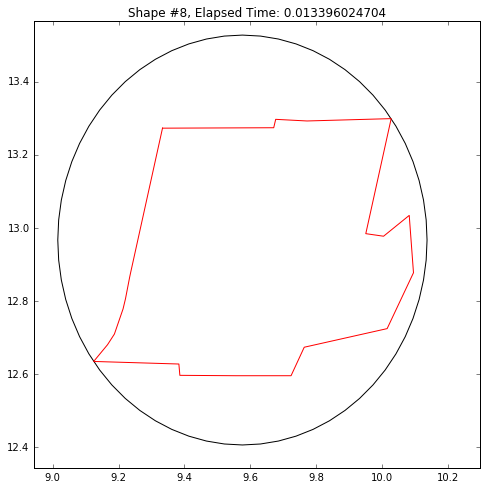

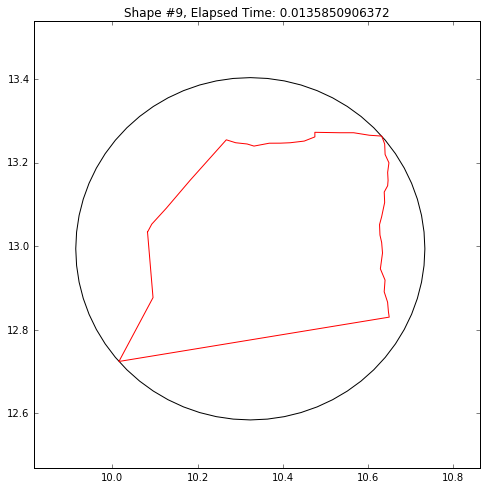

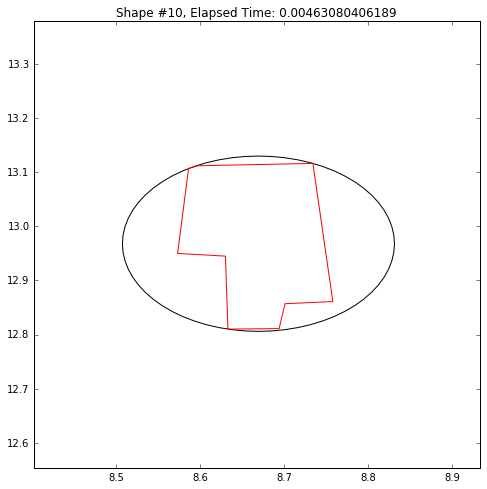

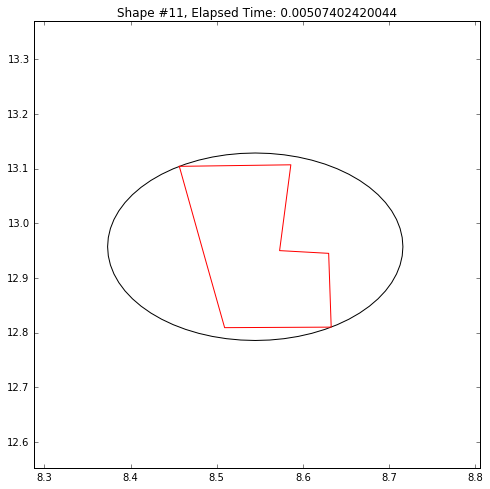

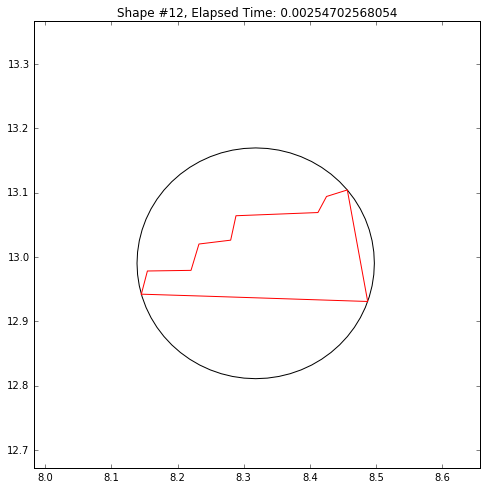

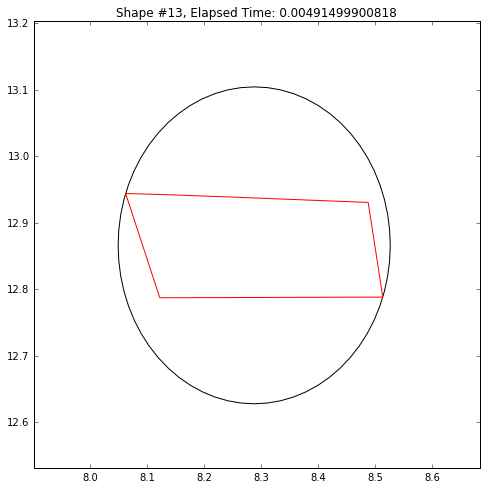

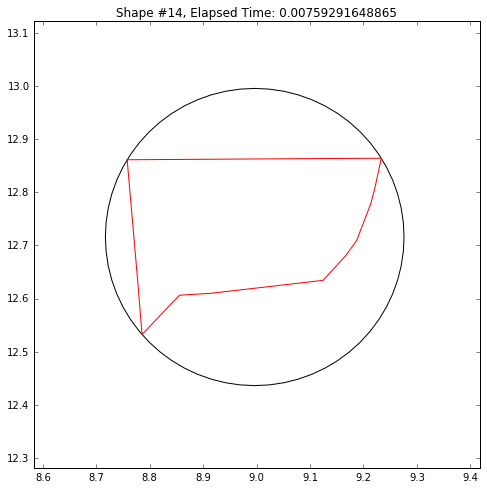

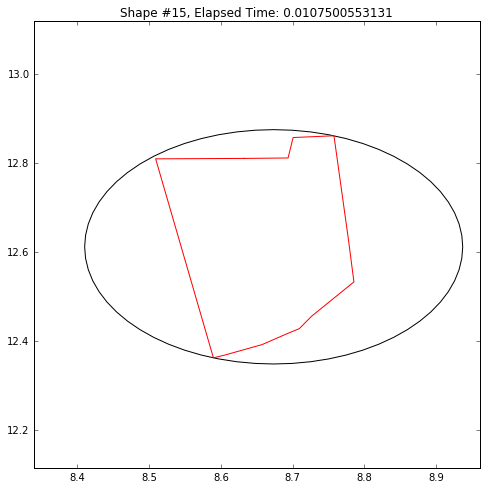

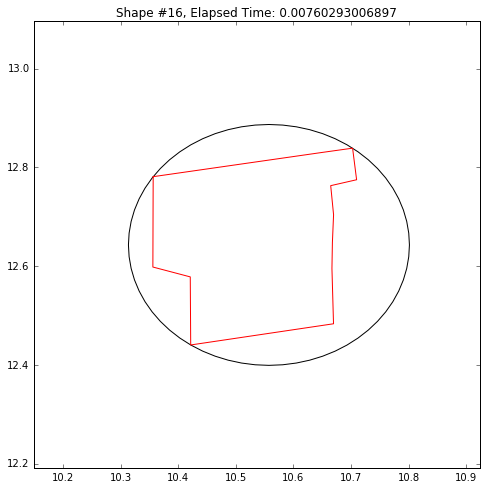

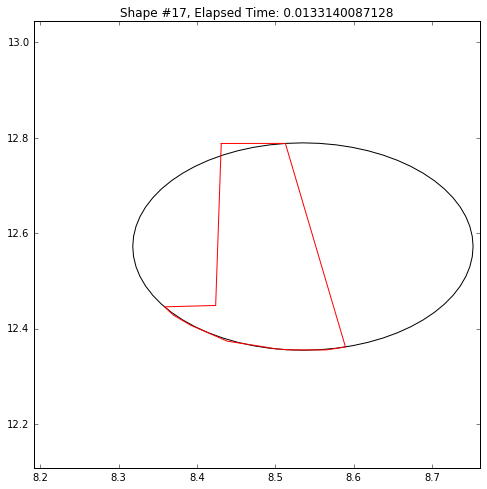

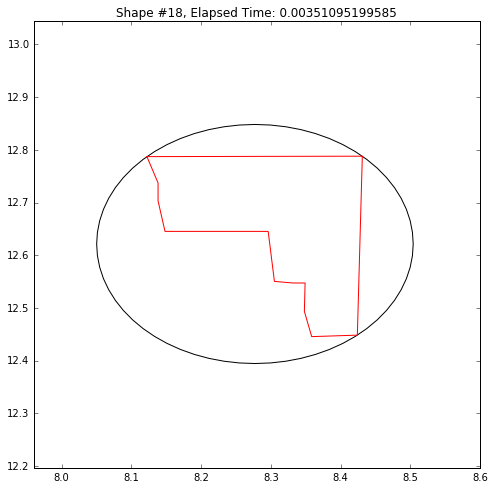

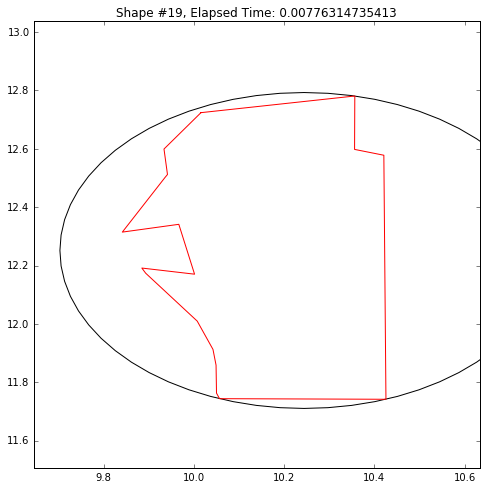

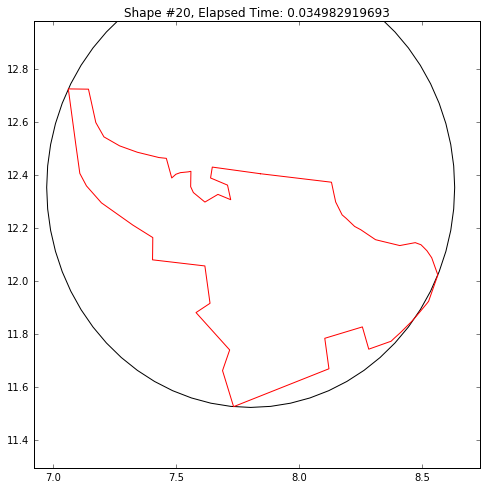

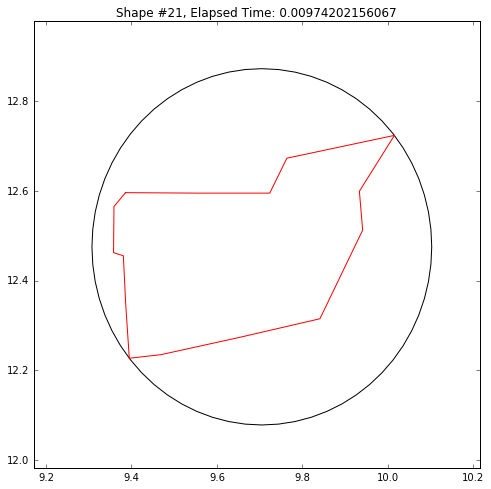

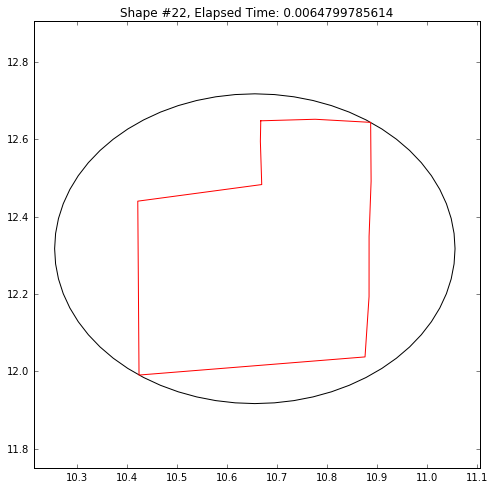

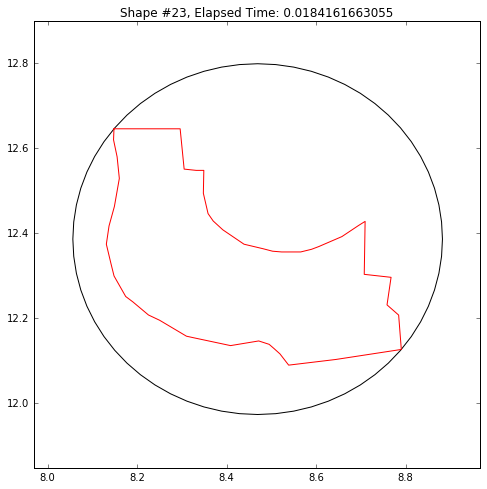

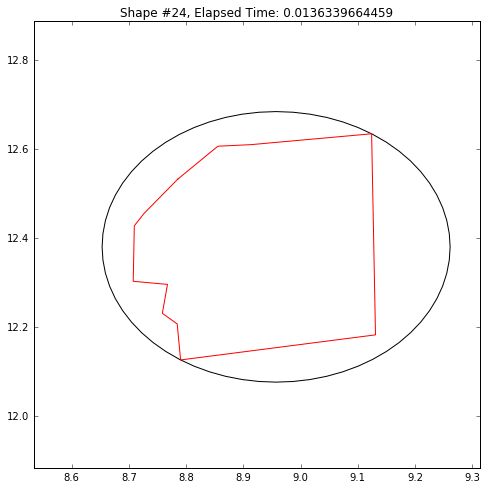

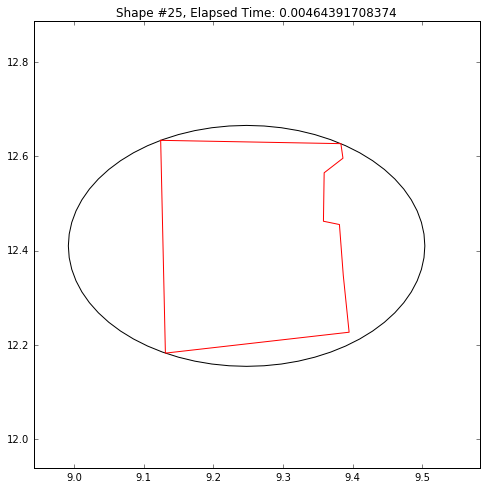

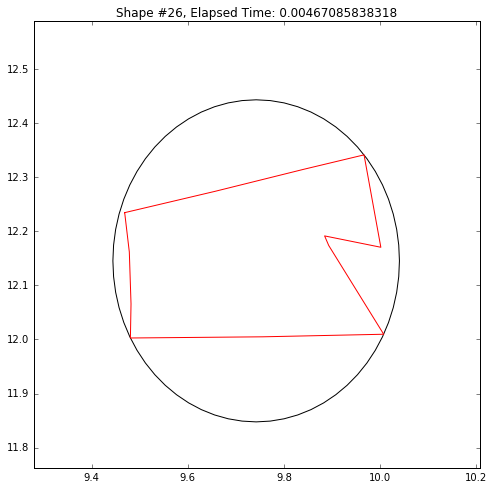

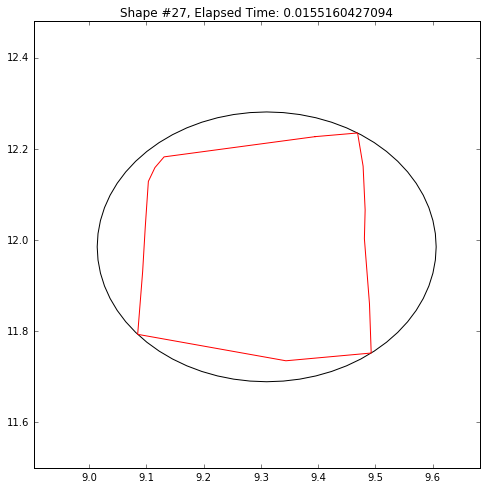

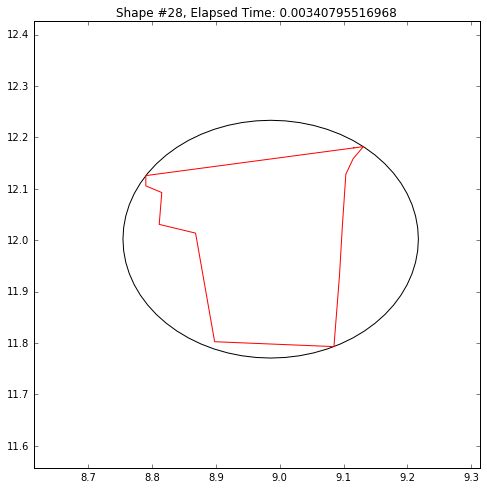

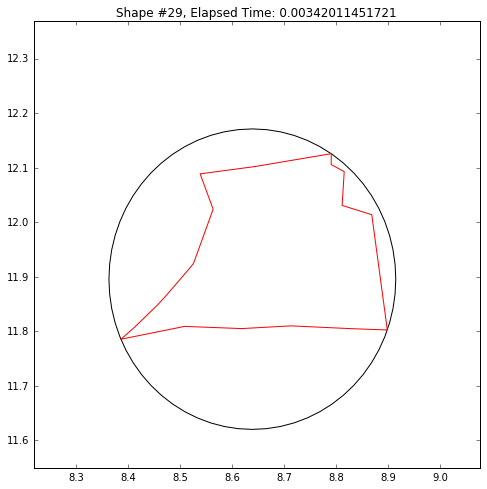

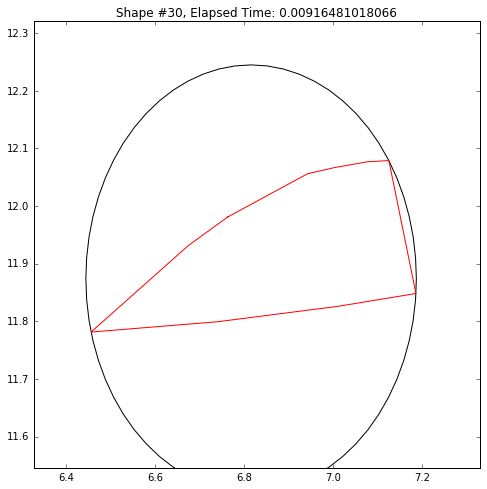

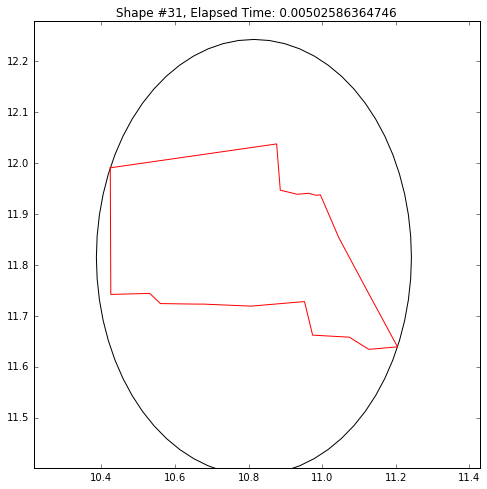

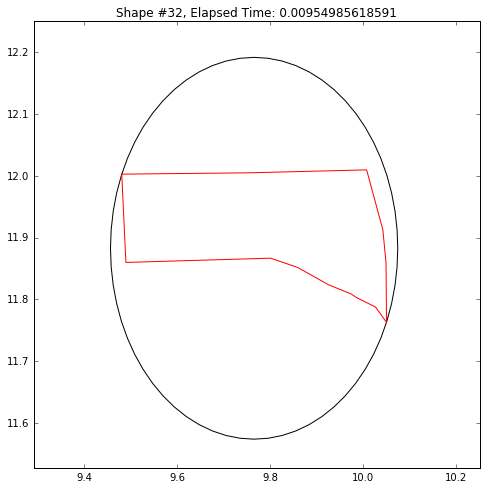

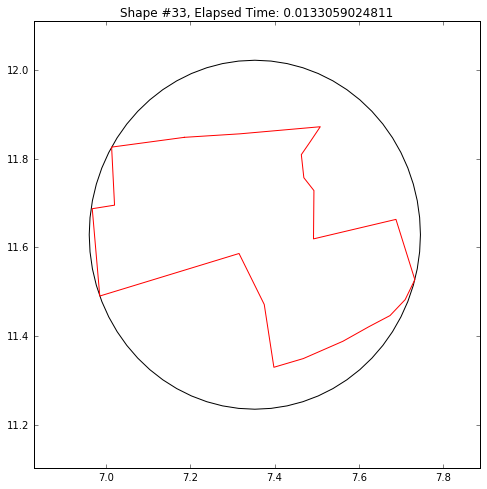

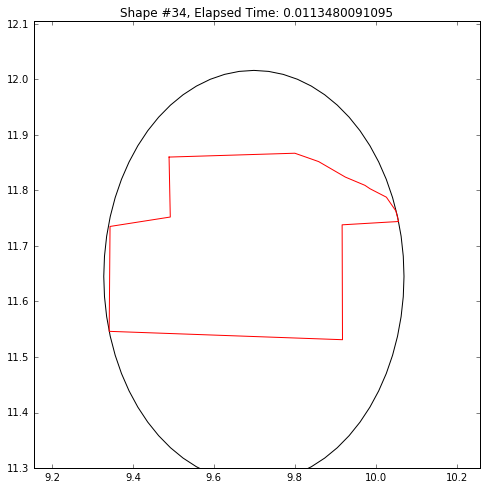

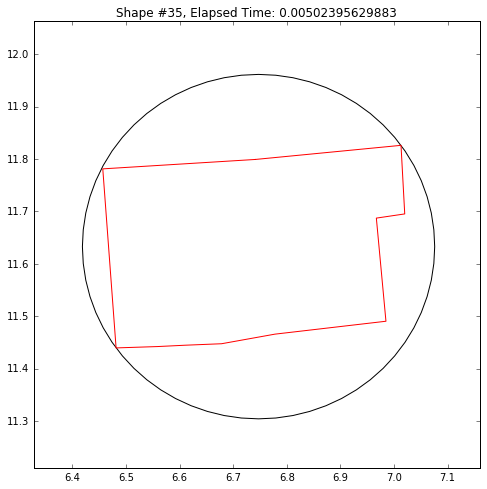

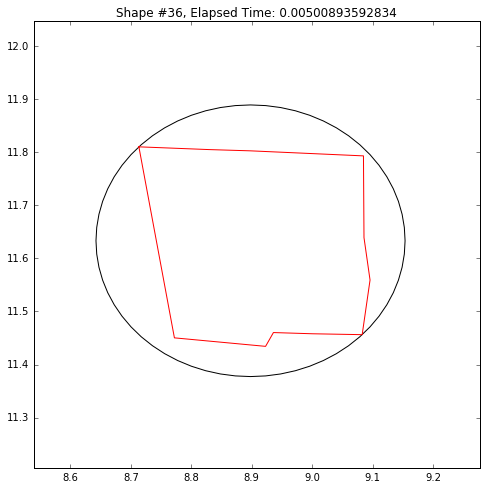

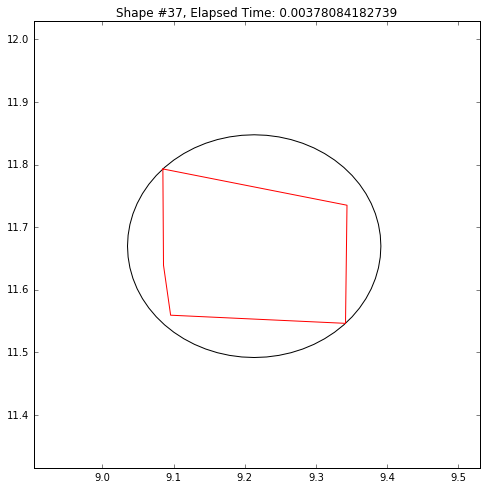

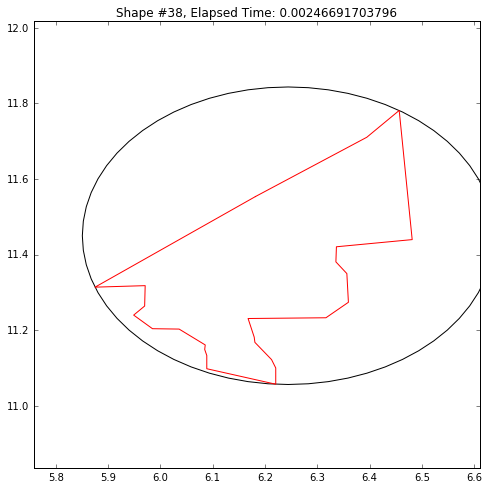

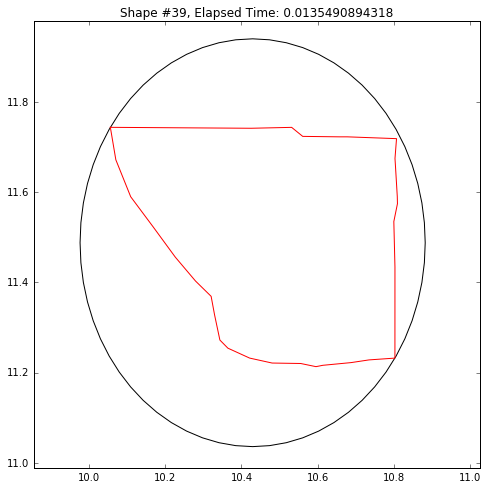

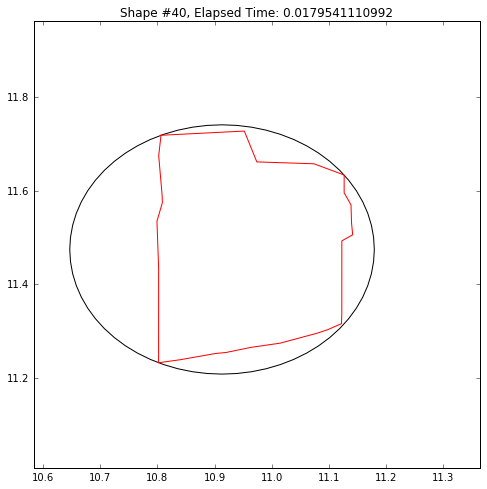

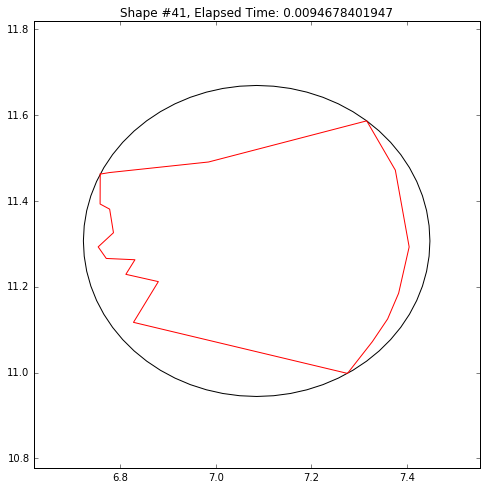

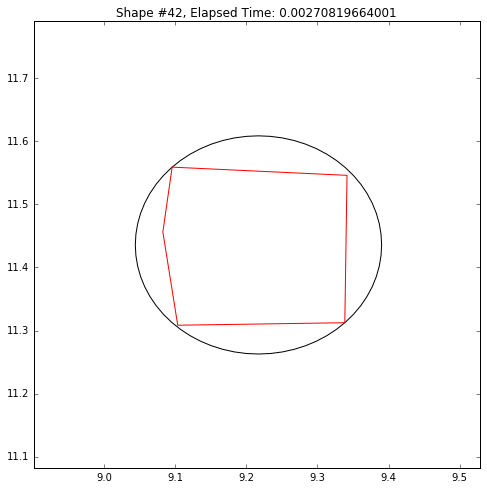

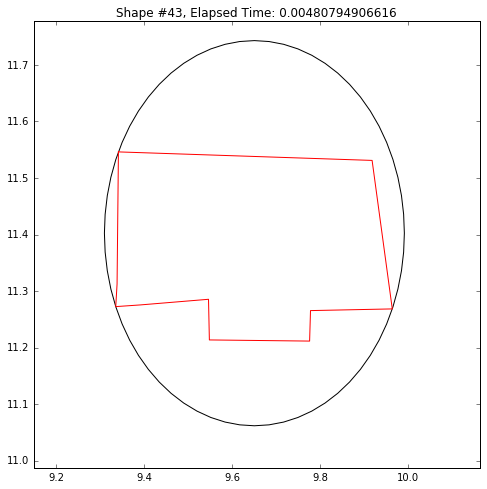

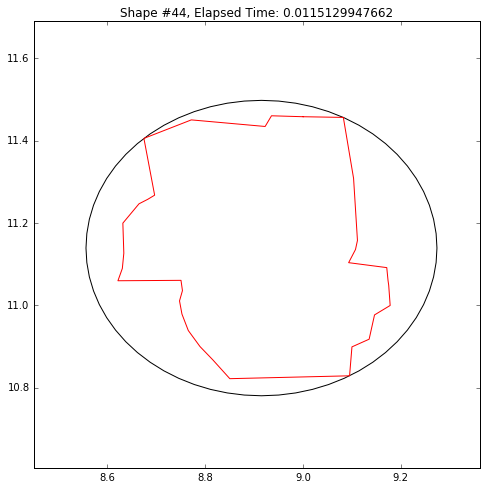

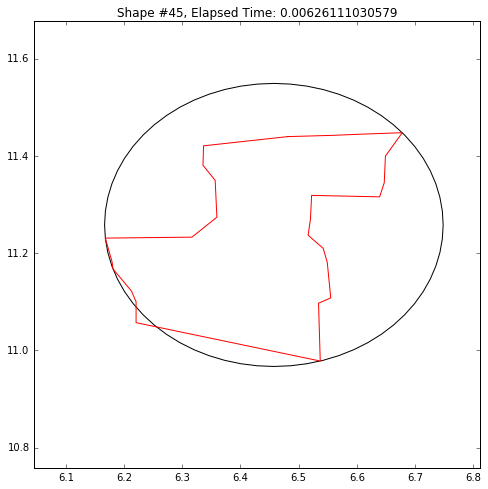

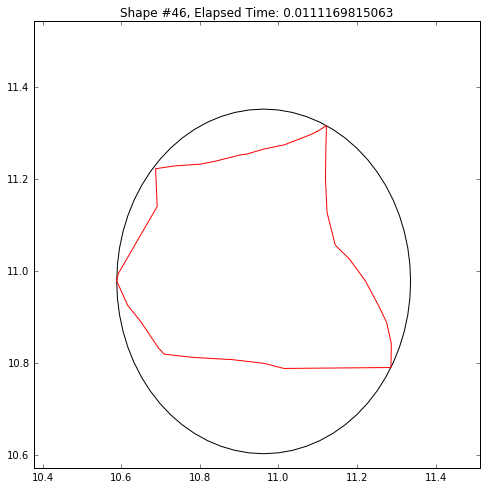

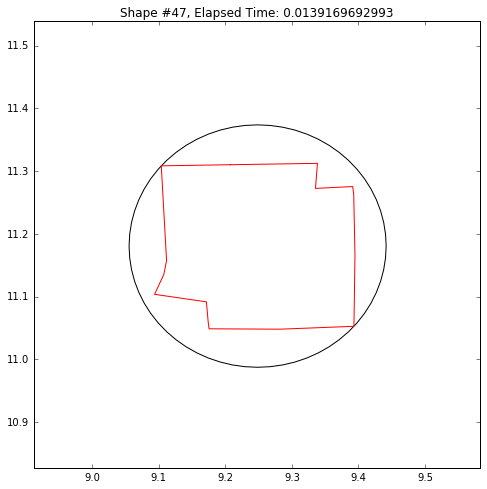

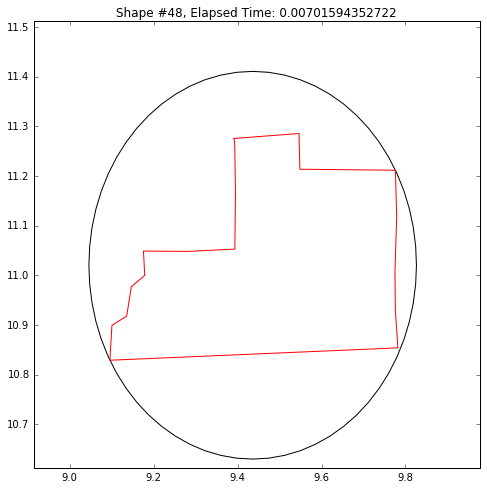

In [21]:
demo_mbc(chains)

Seems as if we're there, in a large part. Now, only shapes 2, 17, 20, and 45 are failing. 

In [158]:
bads = [2, 17, 20, 45]

In [250]:
current = bads.pop()
print(current)

17


In [501]:
current = 45

In [502]:
removed = []
i = 0

In [503]:
POINTS = [point for part in data[current].parts for point in part]

In [504]:
pset = [point for part in data[current].parts for point in part[:-1]]

In [505]:
pset = [pset[j] for j in com.mbc.ConvexHull(pset).vertices]

In [506]:
len(pset)

8

In [509]:
parray = com.np.array(pset)

In [514]:
parray.min(0)

array([  6.16758585,  10.9780302 ])

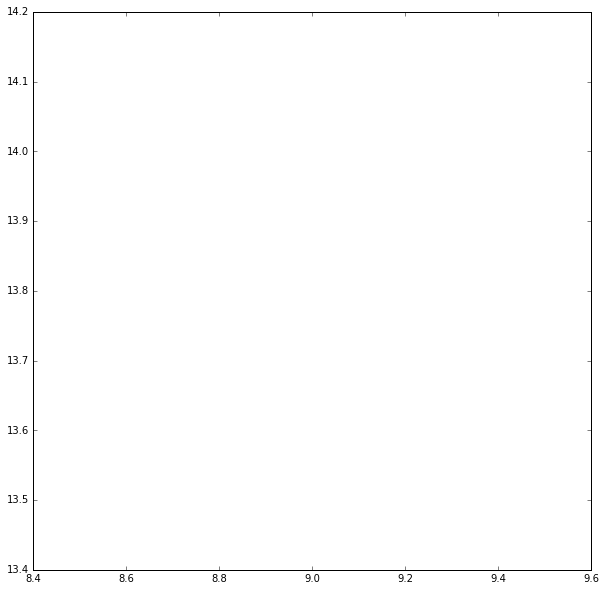

In [507]:
fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,1,1)
plt.plot([p[0] for p in POINTS], [p[1] for p in POINTS], 'k', linewidth=1)
plt.plot([p[0] for p in pset], [p[1] for p in pset], 'm--', linewidth=1.5)
plt.axis([8.4,9.6,13.4, 14.2])
plt.savefig('not_working/{}.png'.format(i))
plt.show()

#### repeat from here

In [490]:
angles = [com.mbc._angle(*com.mbc._neighb(p,pset)) for p in pset]
circles = [com.mbc._circle(*com.mbc._neighb(p,pset)) for p in pset]
radii = [c[0] for c in circles]
lexord = com.mbc.np.lexsort((radii, angles))
lexmax = lexord[-1]

In [491]:
if not angles[lexmax] <= com.mbc.PI/2.:
    print('Failure!')
    print("""Angle: {a} (threshold is {pi2})
Center: {c}
Radius: {r}
Remaining: {rem}""".format(a=angles[lexmax], 
                      c=circles[lexmax][-1],
                      r=radii[lexmax], 
                      pi2 = com.mbc.PI /2., 
                      rem = len(pset)))
    removed.append((lexmax, pset.pop(lexmax)))
    i+=1

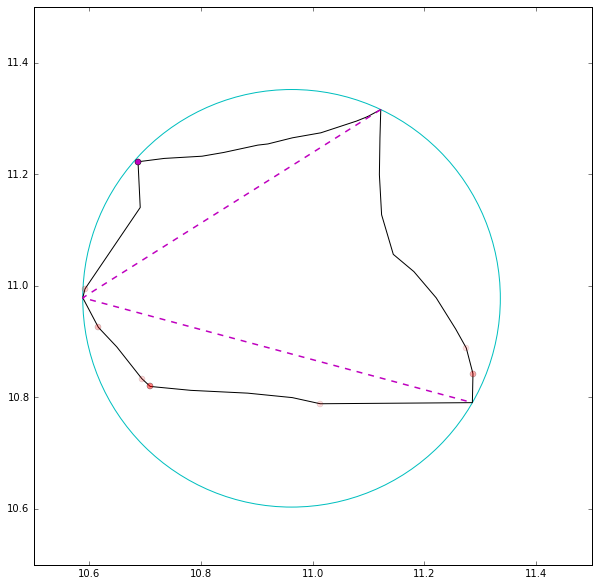

In [492]:
fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,1,1)
plt.plot([p[0] for p in POINTS], [p[1] for p in POINTS], 'k', linewidth=1)
plt.plot([p[0] for p in pset], [p[1] for p in pset], 'm--', linewidth=1.5)
plt.plot(removed[-1][-1][0], removed[-1][-1][1], 'mo')
for j, (_, (px, py)) in enumerate(removed[:-1]):
    plt.plot(px,py, 'ro', alpha=1./(len(removed)-j))
solution = plt.Circle(circles[lexmax][-1], radius=circles[lexmax][0], 
                      fill=False, ec='c')
ax1.add_patch(solution)
plt.axis([10.5,11.5,10.5,11.5])
plt.savefig('working/{}.png'.format(i))
plt.show()

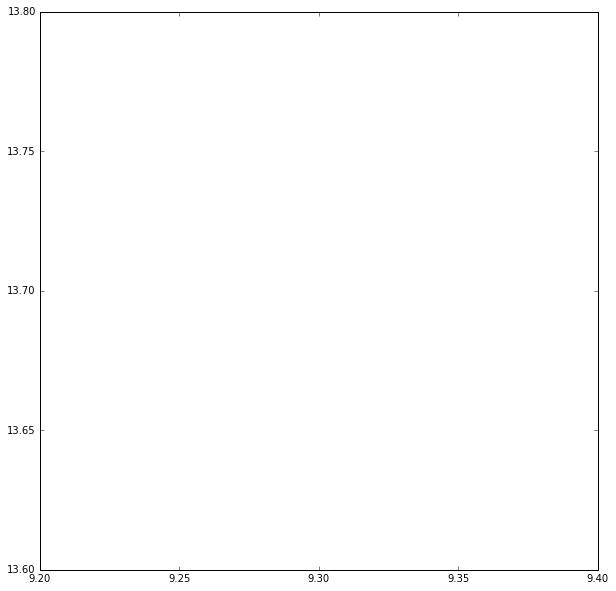

In [477]:
fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,1,1)
plt.plot([p[0] for p in POINTS], [p[1] for p in POINTS], 'k', linewidth=1)
plt.plot([p[0] for p in pset], [p[1] for p in pset], 'm--', linewidth=1.5)
plt.plot(removed[-1][-1][0], removed[-1][-1][1], 'mo')
for j, (_, (px, py)) in enumerate(removed[:-1]):
    plt.plot(px,py, 'ro', alpha=1./(len(removed)-j))
solution = plt.Circle(circles[lexmax][-1], radius=circles[lexmax][0], 
                      fill=False, ec='c')
ax1.add_patch(solution)
plt.axis([9.2,9.4,13.6,13.8])
plt.savefig('not_working/detail.png'.format(i))
plt.show()

In [301]:
d.euclidean(removed[-1][-1], circles[lexmax][-1])

0.2399356616123199

In [247]:
circles[lexmax]

(0.8293148329129162, (7.802713598656066, 12.353784132188242))

In [249]:
circles

[(0.829314832912937, (7.802713598656066, 12.353784132188242)),
 (0.8293148329129162, (7.802713598656066, 12.353784132188242)),
 (0.8293148329129327, (7.802713598656066, 12.353784132188242))]